In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import dump, load
import scipy.io
import xgboost as xgb


In [7]:
mat_data = scipy.io.loadmat('MNIST-LeNet5.mat')
print('keys -> ', mat_data.keys())

X = mat_data['train_fea']
Y = mat_data['train_gnd']
Y = Y - 1

# val_x = X[50000:60000]
# val_y = Y[50000:60000]
# X = X[0:50000]
# Y = Y[0:50000]
test_X = mat_data['test_fea']
test_Y = mat_data['test_gnd']
test_Y -= 1

print('train data shape -> ', X.shape)
print('test data shape -> ', test_X.shape)
print('train labels shape -> ', Y.shape)
print('test labels shape -> ', test_Y.shape)


keys ->  dict_keys(['__header__', '__version__', '__globals__', 'test_fea', 'test_gnd', 'train_fea', 'train_gnd'])
train data shape ->  (60000, 800)
test data shape ->  (10000, 800)
train labels shape ->  (60000, 1)
test labels shape ->  (10000, 1)


In [24]:
# max_depth = [2, 4, 6, 8, 10, 20]
# eta_vals = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1, 2, 5, 10]
# n_est = [1, 5, 10, 20, 50, 100]
max_depth = [40]
eta_vals = [0.01]
n_est = [100]
best_acc = 0
best_params = {}
best_model = None
values = []

In [25]:
for depth in max_depth:
    for et in eta_vals:
        for n in n_est:
            params = {'max_depth': depth,
                      'eta': et, #learning rate
                      'n_estimators': n, #number of trees
                      'objective': 'multi:softmax', 
                      'num_class': 10,
                      'verbosity': 0,
                      'tree_method': 'gpu_hist'
                      }
            clf = xgb.XGBClassifier(**params)
            clf.fit(X, Y)
            y_pred = clf.predict(test_X)
            accuracy = accuracy_score(test_Y, y_pred)
            if accuracy > best_acc:
                best_acc = accuracy
                best_params = params
                best_model = clf
            print(f"max_depth: {depth}, eta: {et}, n_estimators: {n}, Accuracy: {accuracy}")
            values.append((depth, et, n, accuracy))
   

max_depth: 40, eta: 0.01, n_estimators: 100, Accuracy: 0.9762


Accuracy ->  0.9762
Best params ->  {'max_depth': 40, 'eta': 0.01, 'n_estimators': 100, 'objective': 'multi:softmax', 'num_class': 10, 'verbosity': 0, 'tree_method': 'gpu_hist'}


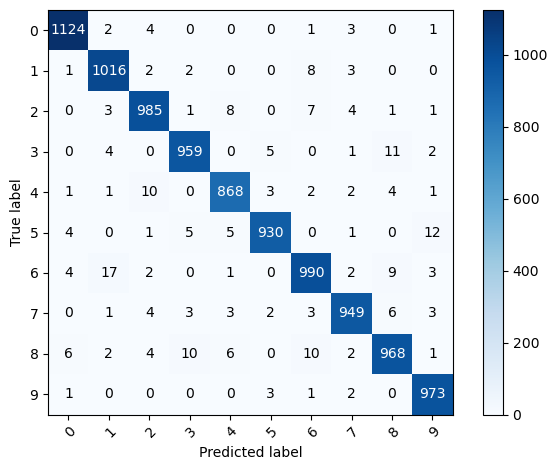

In [26]:
y_pred = best_model.predict(test_X)
print('Accuracy -> ', accuracy_score(test_Y, y_pred))
print('Best params -> ', best_params)
cm = confusion_matrix(test_Y, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(10),
       yticklabels=np.arange(10),
       xlabel='Predicted label',
       ylabel='True label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.0f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

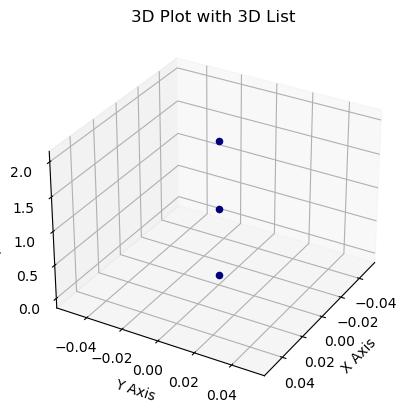

In [27]:
# plot depth vs accuracy and n_estimators vs accuracy
acc_list = [[[t[0], t[2], t[3]] for t in values]]
# 0 = depth, 2 = n_estimators, 3 = accuracy

# Convert the 3D list to a numpy array
data_array = np.array(acc_list)

# Create a 3D plot using the scatter function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(data_array.shape[0]):
    for j in range(data_array.shape[1]):
        for k in range(data_array.shape[2]):
            ax.scatter(i, j, k, c=data_array[i, j, k], cmap='jet')

# Add axis labels and a title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Plot with 3D List')

# Show the plot
ax.view_init(elev=30, azim=30)
plt.show()